# MaxEnt Classification

### A. Concepts (ME as an Instance of Generalized Linear Regression)

** a. Classify By Probability **

* **Probability of a Classifying as $c$**: 
    * $p(c|x) = \frac{p(c,x)}{p(x)} = \frac{p(x|c)p(c)}{\sum_cp(x|c)p(c)} = \frac{exp\left(\sum_{i=0}^Nw_{ci}f_i\right)}{\sum_{c'\in C}exp\left(\sum_{i=0}^Nw_{c'i}f_i\right)} = \frac{exp\left(\sum_{i=0}^Nw_{ci}f_i(c,x)\right)}{\sum_{c'\in C}exp\left(\sum_{i=0}^Nw_{c'i}f_i(c',x)\right)}$
    * $f(c/c',x)$ is an indicator function indicating the presence/absence of a feature, which is binary-valued $\{0,1\}$. 


* **Best Class $\hat{c}$**: 
    * $\hat{c} = argmax_{c\in C}p(c|x)$.


* **Best Weights $\hat{w}$**:
    * $\hat{w} = argmax_w\sum_ilogp(y^{(i)}|x^{(i)})$, where $(x^{(i)}, y^{(i)})$ are training pairs.


* **NB**: 
    * For an excellent explanation for the use of exponential, cf. J&M ch6.6:26-8.
    * cf. J&M ch6.7:30-1, the original derivation in eq.6.79 is notationally incorrect, specifically $\sum_Cp(c|x)$ is equal to 1, instead of $\sum_{c'\in C}exp\left(\sum_{i=0}^Nw_{c'i}f_i\right)$.
    * Caveat: in practice, in sequence classification, MaxEnt classification described here is used as a part of a larger classifier, because our goal is to find the *best sequence of classification*, not *single-best classification for each unit in a sequence*.

** b. Finding Best Weights**

* **Maximizing Loglikelihood (i.e. MLE)**: (notation: $C$ for 'all classes' $D$ for all corresponding data)

    * $logp(C|D,w) = \sum_{(c,d)\in(C,D)}log\frac{exp\sum_iw_if_i(c,d)}{\sum_{c'}exp\sum_iw_if_i(c,d)} = \sum_{(c,d)\in(C,D)}logexp\sum_iw_if_i(c,d) - \sum_{(c,d)\in(C,D)}log\sum_{c'}exp\sum_iw_if_i(c',d)$, the optimization goal is to find $w$ that maximizes $logp(C|D,w)$.
    
    * $\frac{\partial logp(C|D,w)}{\partial w_i} = \sum_{(c,d)\in(C,D)}f_i(c,d) - \sum_{(c,d)\in(C,D)}\sum_{c'}p(c'|d,w)f_i(c',d)$, where $p(c'|d,w) = \frac{exp\sum_iw_if_i(c',d)}{\sum_{c''}exp\sum_iw_if_i(c'',d)}$ (i.e. empirical - predicted. cf. Stanford MaxEnt Tutorial (SMT hereafter):24-7, http://people.eecs.berkeley.edu/~klein/papers/maxent-tutorial-slides.pdf)


* **Maximizing Posterior Probability (i.e. MAP)**:

    * We have some prior distribution of the weights: $p(w)$, and the likelihood of a class assignments $C$ given the data and weights is $p(C|D,w)$. Then, the posterior probability of the classification will be $p(w)\cdot p(C|D,w) = p(C,w|D)$. The optimization goal now is then finding the $w$ that maximizes the log-probability $logp(C,w|D)$, where $logp(C,w|D) = logp(w) + logp(C|D,w)$.
    
    * $\frac{\partial logp(C,w|D)}{\partial w_i} = \sum_{(c,d)\in(C,D)}f_i(c,d) - \sum_{(c,d)\in(C,D)}\sum_{c'}p(c'|d,w)f_i(c',d) - \frac{(w_i - \mu_i)}{\sigma^2}$, assuming the prior $p(w)$ is *Gaussian*, i.e. $p(w_i) = \frac{1}{\sigma\sqrt{2\pi}}exp\left(-\frac{(w_i-\mu_i)^2}{2\sigma^2}\right)$, where $2\sigma^2 = 1$ works well empirically (cf. SMT:55).
    

* Implementation Note: 
    * Writing $log\frac{*}{*}$ as $log* - log*$ comes with the benefit of ...
        * Intuitive explanation, i.e. emprical - actual.
        * Easy derivative representation.
    * In computing the cost function, $J(w) = -logp(C|D,w)$, for instance, this not necessary (coding following the original function is usually simpler).

### B. Basic Optimization Demo (Logistic Regression)

** a. Math ** (cf. J&M ch6.6:29-30)

* **Logistic Function**: $p(y=1|x) = \frac{1}{1+e^{-w\cdot x}}$; $p(y=0|x) = 1 - p(y=1|x) = \frac{e^{-w\cdot x}}{1+e^{-w\cdot x}}$.


* **Cost Function**: $J(w) = -\frac{1}{n}\sum_{i=1}^ny^{(i)}log\frac{1}{1+e^{-w\cdot x^{(i)}}} - (1-y^{(i)})log\frac{e^{-w\cdot x^{(i)}}}{1+e^{-w\cdot x^{(i)}}}$.


* **Gradient**: $\frac{\partial J(w)}{\partial w_j} = \frac{1}{n}\sum_{i=1}^n(\frac{1}{1+e^{-w\cdot x_i}} - y_i)x_{ij}$, where $x_{ij}$ is the $j$th element in the vector $x_i$.


* **NB**: $n$ is *batch size*.

In [6]:
import os
os.chdir('/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/BASIC_TOPICS/NLP/DATA/')

In [76]:
import pandas as pd
import numpy as np
from __future__ import division
import scipy.optimize as sco

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

** b. Step-By-Step Demo **

In [10]:
data = pd.read_csv('carmpg.txt', sep='\s+', 
                  names=['mpg','cylinders','displacement','horsepower',
                         'weight','acceleration','model_year','origin','car_name'])
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


In [186]:
# TASK: mpg = beta0 + beta1*horsepower + beta2*acceleration

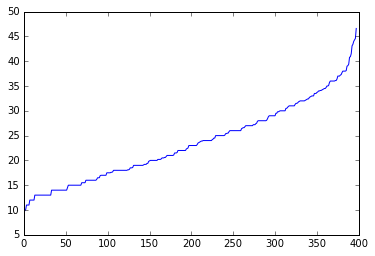

In [42]:
# TARGET
plt.plot(sorted(data['mpg']))

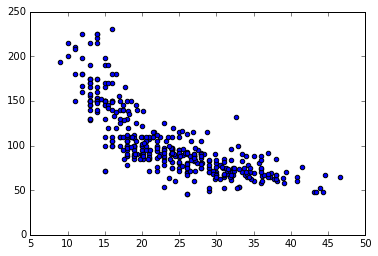

In [26]:
# 1 NEGATIVE PREDICTOR
plt.scatter(data['mpg'],data['horsepower'])

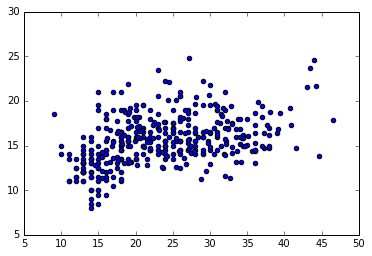

In [40]:
# 1 POSITIVE PREDICTOR
plt.scatter(data['mpg'],data['acceleration'])

In [21]:
mean = np.mean(data['mpg'])
data['high_mpg'] = map(lambda x:1 if x>mean else 0, data['mpg'])

In [22]:
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name,high_mpg
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu,0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320,0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite,0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst,0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino,0


In [47]:
data[['horsepower','acceleration']].head()

,horsepower,acceleration
0,130.0,12.0
1,165.0,11.5
2,150.0,11.0
3,150.0,12.0
4,140.0,10.5


In [123]:
def normalize(x):
    return ((x - np.mean(x)) / np.std(x))[:,np.newaxis]

In [281]:
X, Y = np.hstack((np.ones((len(data),1)),
                  normalize(np.array(data['horsepower'])),
                  normalize(np.array(data['acceleration'])))), \
       np.array(data['high_mpg'])

In [282]:
W = np.random.random(3) # bias, W_1 for X_1 horsepower, W_2 for X_2 acceleration.

In [283]:
def fx(W_i,X_i):
    return 1 / (1 + np.exp(-np.dot(W_i,X_i)))
def log(Z): # Z = dot(W,X)
    return np.nan_to_num(np.log(Z))

In [284]:
def cost(W,X,Y):
    return 1/len(X) * sum(- Y_i*log(fx(W,X_i)) - (1-Y_i)*log(1-fx(W,X_i))
                          for X_i,Y_i in zip(X,Y))
def grad(W,X,Y):
    return 1/len(X) * sum([ (fx(W,X_i)-Y_i)*X_i for X_i,Y_i in zip(X,Y) ])

In [285]:
cost(W,X,Y)

0.76157348234820277

In [286]:
W

array([ 0.26331889,  0.39638329,  0.62669563])

In [287]:
X

array([[ 1.        ,  0.67602454, -1.29549834],
       [ 1.        ,  1.58967758, -1.47703779],
       [ 1.        ,  1.19811199, -1.65857724],
       ..., 
       [ 1.        , -0.52477659, -1.4407299 ],
       [ 1.        , -0.65529846,  1.10082237],
       [ 1.        , -0.57698534,  1.39128549]])

In [288]:
Y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 1,

In [289]:
print W.shape, X.shape, Y.shape

(3,) (398, 3) (398,)


In [290]:
%%time
optimizer = sco.fmin_bfgs(cost, x0=W, fprime=grad, args=(X,Y))

Optimization terminated successfully.
         Current function value: 0.323911
         Iterations: 19
         Function evaluations: 20
         Gradient evaluations: 20
CPU times: user 439 ms, sys: 5.27 ms, total: 445 ms
Wall time: 441 ms


In [291]:
print optimizer

[-1.13057636 -4.96453008 -1.17704681]


In [293]:
%%time
optimizer = sco.fmin_ncg(cost, x0=W, fprime=grad, args=(X,Y))

Optimization terminated successfully.
         Current function value: 0.323911
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 54
         Hessian evaluations: 0
CPU times: user 282 ms, sys: 6.19 ms, total: 289 ms
Wall time: 284 ms


In [294]:
print optimizer

[-1.13057408 -4.96448731 -1.17702815]


** c. Put It All Together **

** Comments: BFGS seems to be more stable than Newton Conjugate-Gradient-Descent. **

In [722]:
import numpy as np
import random
from scipy.optimize import fmin_ncg, fmin_bfgs
from copy import deepcopy

In [723]:
def train_test_split(data, train_perc=.8):
    cutoff = int(len(data)*train_perc)
    return data[:cutoff], data[cutoff:]

In [724]:
class LogisticRegression:
    
    def __init__(self, train, test, nepochs=1, batch_size=10):
        self.train = deepcopy(train)
        self.test = deepcopy(test)
        self.config = {'nepochs':nepochs, 'batch_size':batch_size}
        self.optimization = {'ncg':fmin_ncg, 'bfgs':fmin_bfgs}
        self.means = np.apply_along_axis(lambda col:np.mean(col),0,X)
        self.stds = np.apply_along_axis(lambda col:np.std(col),0,X)
    
    def _normalize(self, X):
        return (X - self.means) / self.stds 
    
    def _shuffle(self, X, Y, seed):
        random.seed(seed)
        random.shuffle(X)
        random.seed(seed)
        random.shuffle(Y)
    
    def _fx(self, W_i, X_i):
        return 1 / (1 + np.exp(-np.dot(W_i,X_i)))
    
    def _log(self, Z_i):
        return np.nan_to_num(np.log(Z_i))
    
    def _cost(self, W, X, Y):
        return 1/len(X) * sum(- Y_i*log(fx(W,X_i)) - (1-Y_i)*log(1-fx(W,X_i))
                              for X_i,Y_i in zip(X,Y))
    
    def _grad(self, W, X, Y):
        return 1/len(X) * sum([ (fx(W,X_i)-Y_i)*X_i for X_i,Y_i in zip(X,Y) ])

    def _predict(self, x):
        pred = self._fx(self.W, x)
        return 1 if pred>.5 else 0
    
    def fit(self, optimization='bfgs', lr=.01, max_iters=100, verbose=0):
        optimize = self.optimization[optimization]
        nepochs, batch_size = self.config['nepochs'], self.config['batch_size']
        X, Y = self.train
        X = self._normalize(X)
        X = np.hstack((np.ones((len(X),1)), X)) # add bias.
        W = np.random.random(X.shape[1])
        num_iters = 0
        for e in xrange(nepochs):
            if e!=0 and e%10==0:
                print "... Epoch: %d" % e
            self._shuffle(X, Y, seed=random.randint(0,1000))
            num_batches = int(np.ceil(len(X) / batch_size)) 
            for idx in xrange(num_batches):
                disp = 1 if (idx==num_batches-1 and verbose==1) else 0 # only print out convergence msg on the last batch.
                X_batch = X[idx*batch_size:(idx+1)*batch_size]
                Y_batch = Y[idx*batch_size:(idx+1)*batch_size]
                W = optimize(self._cost, x0=W, fprime=self._grad, epsilon=lr, 
                             args=(X_batch,Y_batch), maxiter=max_iters, disp=disp)
            num_iters += len(X)
        print "Training Complete After %d Iterations" % num_iters
        print "Cost: %.6f" % self._cost(W, X, Y)
        self.W = W 
    
    def evaluate(self):
        X, Y = self.test
        X = self._normalize(X)
        X = np.hstack((np.ones((len(X),1)), X)) # add bias.
        W = self.W
        num_cor = 0
        for X_i,Y_i in zip(X,Y):
            hat = self._predict(X_i)
            num_cor += 1 if hat==Y_i else 0
        print "Accuracy: %.2f%%" % (num_cor/len(X)*100)

In [725]:
X, Y = np.hstack((np.array(data['horsepower'])[:,np.newaxis],
                  np.array(data['acceleration'])[:,np.newaxis])), \
       np.array(data['high_mpg'][:,np.newaxis])

In [726]:
(X_train, X_test), (Y_train, Y_test) = train_test_split(X), train_test_split(Y)

In [676]:
logreg = LogisticRegression(train=(X_train,Y_train), test=(X_test,Y_test), nepochs=100, batch_size=10)

In [677]:
logreg.fit(verbose=0)

... Epoch: 10
... Epoch: 20
... Epoch: 30
... Epoch: 40
... Epoch: 50
... Epoch: 60
... Epoch: 70
... Epoch: 80
... Epoch: 90
Training Complete After 31800 Iterations
Cost: 0.000000


In [678]:
logreg.evaluate()

Accuracy: 91.25%


In [727]:
logreg = LogisticRegression(train=(X_train,Y_train), test=(X_test,Y_test), nepochs=100, batch_size=len(X_train))

In [728]:
logreg.fit(optimization='ncg', lr=.0001, verbose=0)

... Epoch: 10
... Epoch: 20
... Epoch: 30
... Epoch: 40
... Epoch: 50
... Epoch: 60
... Epoch: 70
... Epoch: 80
... Epoch: 90
Training Complete After 31800 Iterations
Cost: 0.000004


In [729]:
logreg.evaluate()

Accuracy: 91.25%


### C. MaxEnt Problem

** a. Describing MaxEnt Problem **

* **Optimization Goal**: Maximizing the data (i.e. MLE or MAP) under the Max Entropy Constraint.

* **MaxEnt Constraint**: 

    * Model-Estimated Expectation of feature $f_j$: $E_pf_j = \sum_{(c,d)\in(C,D)}p(c,d)f_j(c,d)$.
    
    * Empirical Expectation of feature $f_j$: $E_{\tilde{p}}f_j = \sum_{(c,d)\in(C,D)}\tilde{p}(c,d)f_j(c,d)$.
    
    * $H(p) = \sum_{(c,d)\in(C,D)}p(c,d)logp(c,d)$ is the largest possible given $E_pf_j = E_{\tilde{p}}f_j$.

** b. A Simple Demo of MaxEnt **

In [743]:
import pandas as pd
import numpy as np

In [741]:
A, B = ['DET','NN'], ['the','bird']
print 'Knowledge of p(A,B):'
pd.DataFrame([[.4,'-'],['-','-']],index=A,columns=B)

Knowledge of p(A,B):


,the,bird
DET,0.4,-
NN,-,-


In [742]:
print 'Definition of f(A,B):'
print 'f(a,b) = 1 if a=DET & b=the'
pd.DataFrame([[1,0],[0,0]],index=A,columns=B)

Definition of f(A,B):
f(a,b) = 1 if a=DET & b=the


,the,bird
DET,1,0
NN,0,0


Entropy: $H = -\sum_{a,b}p(a,b)logp(a,b)$

In [780]:
print 'p(A,B) that gives Max Entropy:'
pd.DataFrame([[.4,.2],[.2,.2]],index=A,columns=B)

p(A,B) that gives Max Entropy:


,the,bird
DET,0.4,0.2
NN,0.2,0.2


In [781]:
print 'Randomly Sample 10 Possible Values for Unknown p(a,b):'
samples = np.random.dirichlet((1,1,1),10) * .6
print samples
print
print "Respective H(p) given E_p-hat = E_p:"
for i in xrange(10):
    H = - .4*np.log(.4) - sum(p_i*np.log(p_i) for p_i in samples[i])
    print H
print
print 'Max H(p) by Inspection: Other p(a,b) Uniform, i.e. p(a,b) = .2'
print - .4*np.log(.4) - 3*(.2*np.log(.2))

Randomly Sample 10 Possible Values for Unknown p(a,b):
[[ 0.2539729   0.32469167  0.02133543]
 [ 0.20553456  0.24412556  0.15033987]
 [ 0.49961698  0.06138116  0.03900186]
 [ 0.12404195  0.01180076  0.46415728]
 [ 0.27031484  0.16571123  0.16397393]
 [ 0.30007187  0.21992499  0.08000314]
 [ 0.20674412  0.09825032  0.29500556]
 [ 0.45689111  0.02273314  0.12037575]
 [ 0.47296001  0.00910585  0.11793414]
 [ 0.12650317  0.03972152  0.43377531]]

Respective H(p) given E_p-hat = E_p:
1.16191776417
1.32080825026
1.01102847117
1.03405469408
1.31447356316
1.26285539083
1.28049685551
1.0652763862
1.01552880968
1.11849777122

Max H(p) by Inspection: Other p(a,b) Uniform, i.e. p(a,b) = .2
1.33217904021


** c. MaxEnt Model in Practice **

* **Optimization**:

    * *Generalized Iterative Scaling (GIS)* (Darroch & Ratcliff 1972)
    
    * *Improved Iterative Scaling (IIS)* (Berger 1997)
    
    * *Limited-Memory Broyden–Fletcher–Goldfarb–Shanno (L-BFGS)*: (Perry 1977; Shanno 1978b)

* **Example**:

    * Gender classifier with names as input.

* **Comments**: 

    * With three algorithms produce similar accuracy performance, L-BFGS is not only much much faster, it also doesn't take a ton of memory to do its thing.

In [783]:
import random
import numpy as np
from nltk import MaxentClassifier
from nltk.corpus import names

In [784]:
names = [(name,'male') for name in names.words('male.txt')] + [(name,'female') for name in names.words('female.txt')]
random.shuffle(names)
print names[:5]

[(u'Franklin', 'male'), (u'Robinet', 'female'), (u'Alvin', 'male'), (u'Rowena', 'female'), (u'Marijo', 'female')]


In [785]:
# DEFINING FEATURES
def gender_features(name):
    features = {}
    features["firstletter"] = name[0].lower()
    features["lastletter"] = name[-1].lower()
    for letter in 'abcdefghijklmnopqrstuvwxyz':
        features["count(%s)" % letter] = name.lower().count(letter)
        features["has(%s)" % letter] = (letter in name.lower())
    return features
print "Example: generated feature set for word 'Gary':"
print gender_features('Gary')

Example: generated feature set for word 'Gary':
{'count(u)': 0, 'has(d)': False, 'count(b)': 0, 'count(w)': 0, 'has(b)': False, 'count(l)': 0, 'count(q)': 0, 'count(n)': 0, 'has(j)': False, 'count(s)': 0, 'count(h)': 0, 'has(h)': False, 'has(y)': True, 'count(j)': 0, 'has(f)': False, 'has(o)': False, 'count(x)': 0, 'has(m)': False, 'count(z)': 0, 'has(k)': False, 'has(u)': False, 'count(d)': 0, 'has(s)': False, 'count(f)': 0, 'lastletter': 'y', 'has(q)': False, 'has(w)': False, 'has(e)': False, 'has(z)': False, 'count(t)': 0, 'count(c)': 0, 'has(c)': False, 'has(x)': False, 'count(v)': 0, 'count(m)': 0, 'has(a)': True, 'has(v)': False, 'count(p)': 0, 'count(o)': 0, 'has(i)': False, 'count(i)': 0, 'has(r)': True, 'has(g)': True, 'count(k)': 0, 'firstletter': 'g', 'count(y)': 1, 'has(n)': False, 'has(l)': False, 'count(e)': 0, 'has(t)': False, 'count(g)': 1, 'count(r)': 1, 'count(a)': 1, 'has(p)': False}


In [822]:
# GENERATE TRAINING & TESTING
featuresets = [(gender_features(name), gender) for (name, gender) in names]
split = len(featuresets)*.8 # train=6355; test=1589 (total=7944).
train, test = featuresets[:int(split)], featuresets[int(split):]

In [823]:
%%time
me_gis = MaxentClassifier.train(train, algorithm='GIS', trace=3, max_iter=100)

  ==> Training (100 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.372
             2          -0.61465        0.628
             3          -0.59944        0.628
             4          -0.58604        0.628
             5          -0.57346        0.634
             6          -0.56165        0.651
             7          -0.55056        0.673
             8          -0.54016        0.690
             9          -0.53039        0.708
            10          -0.52123        0.717
            11          -0.51262        0.728
            12          -0.50454        0.735
            13          -0.49693        0.743
            14          -0.48976        0.751
            15          -0.48301        0.756
            16          -0.47664        0.759
            17          -0.47063        0.763
            18          -0.46494        0.767
            19          -0.45956        0.771
 

In [828]:
%%time
me_iis = MaxentClassifier.train(train, algorithm='IIS', trace=3, max_iter=100)

  ==> Training (100 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.372
             2          -0.61334        0.628
             3          -0.59890        0.628
             4          -0.58530        0.629
             5          -0.57254        0.635
             6          -0.56057        0.653
             7          -0.54934        0.675
             8          -0.53882        0.692
             9          -0.52897        0.709
            10          -0.51972        0.718
            11          -0.51105        0.730
            12          -0.50291        0.737
            13          -0.49526        0.745
            14          -0.48807        0.753
            15          -0.48129        0.757
            16          -0.47490        0.760
            17          -0.46888        0.764
            18          -0.46318        0.768
            19          -0.45780        0.772
 

In [834]:
print "GIS: %.2f%%" % (classify.accuracy(me_gis,test)*100)
print "IIS: %.2f%%" % (classify.accuracy(me_iis,test)*100)

GIS: 80.24%
IIS: 80.18%


In [831]:
%%time
me_lbfgs = MaxentClassifier.train(train, algorithm='megam', trace=3, max_iter=100)

CPU times: user 1.01 s, sys: 22.8 ms, total: 1.03 s
Wall time: 4.17 s


In [835]:
print "L-BFGS: %.2f%%" % (classify.accuracy(me_lbfgs,test)*100)

L-BFGS: 80.87%


In [872]:
featuresets[0]

({'count(a)': 1,
  'count(b)': 0,
  'count(c)': 0,
  'count(d)': 0,
  'count(e)': 0,
  'count(f)': 1,
  'count(g)': 0,
  'count(h)': 0,
  'count(i)': 1,
  'count(j)': 0,
  'count(k)': 1,
  'count(l)': 1,
  'count(m)': 0,
  'count(n)': 2,
  'count(o)': 0,
  'count(p)': 0,
  'count(q)': 0,
  'count(r)': 1,
  'count(s)': 0,
  'count(t)': 0,
  'count(u)': 0,
  'count(v)': 0,
  'count(w)': 0,
  'count(x)': 0,
  'count(y)': 0,
  'count(z)': 0,
  'firstletter': u'f',
  'has(a)': True,
  'has(b)': False,
  'has(c)': False,
  'has(d)': False,
  'has(e)': False,
  'has(f)': True,
  'has(g)': False,
  'has(h)': False,
  'has(i)': True,
  'has(j)': False,
  'has(k)': True,
  'has(l)': True,
  'has(m)': False,
  'has(n)': True,
  'has(o)': False,
  'has(p)': False,
  'has(q)': False,
  'has(r)': True,
  'has(s)': False,
  'has(t)': False,
  'has(u)': False,
  'has(v)': False,
  'has(w)': False,
  'has(x)': False,
  'has(y)': False,
  'has(z)': False,
  'lastletter': u'n'},
 'male')

In [848]:
t = me_lbfgs.prob_classify(gender_features('John'))

In [843]:
me_lbfgs.classify(gender_features('John'))

'male'

In [867]:
t.prob('male')

0.70178714993630598

# MaxEnt Markov Model

### A. Concept

** a. HMM vs. MEMM: Generative vs. Discriminative **

* **Common Goal**: Given an observation $W$ (e.g. a word), what is the class $T$ of the observation (e.g. a POS tag)?


* **Generative Method (HMM)**: (cf. J&M ch6.8:37-8,eq.6.95)

    * $\hat{T} = argmax_TP(T|W) = argmax_TP(W|T)P(T) = argmax_T\prod_iP(word_i|tag_i)\prod_iP(tag_i|tag_{i-1})$.
    

* **Discriminative Method (MEMM)**: (cf. ibid.,eq.6.96)

    * $\hat{T} = argmax_TP(T|W) = argmax_T\prod_iP(tag_i|word_i,tag_{i-1})$.

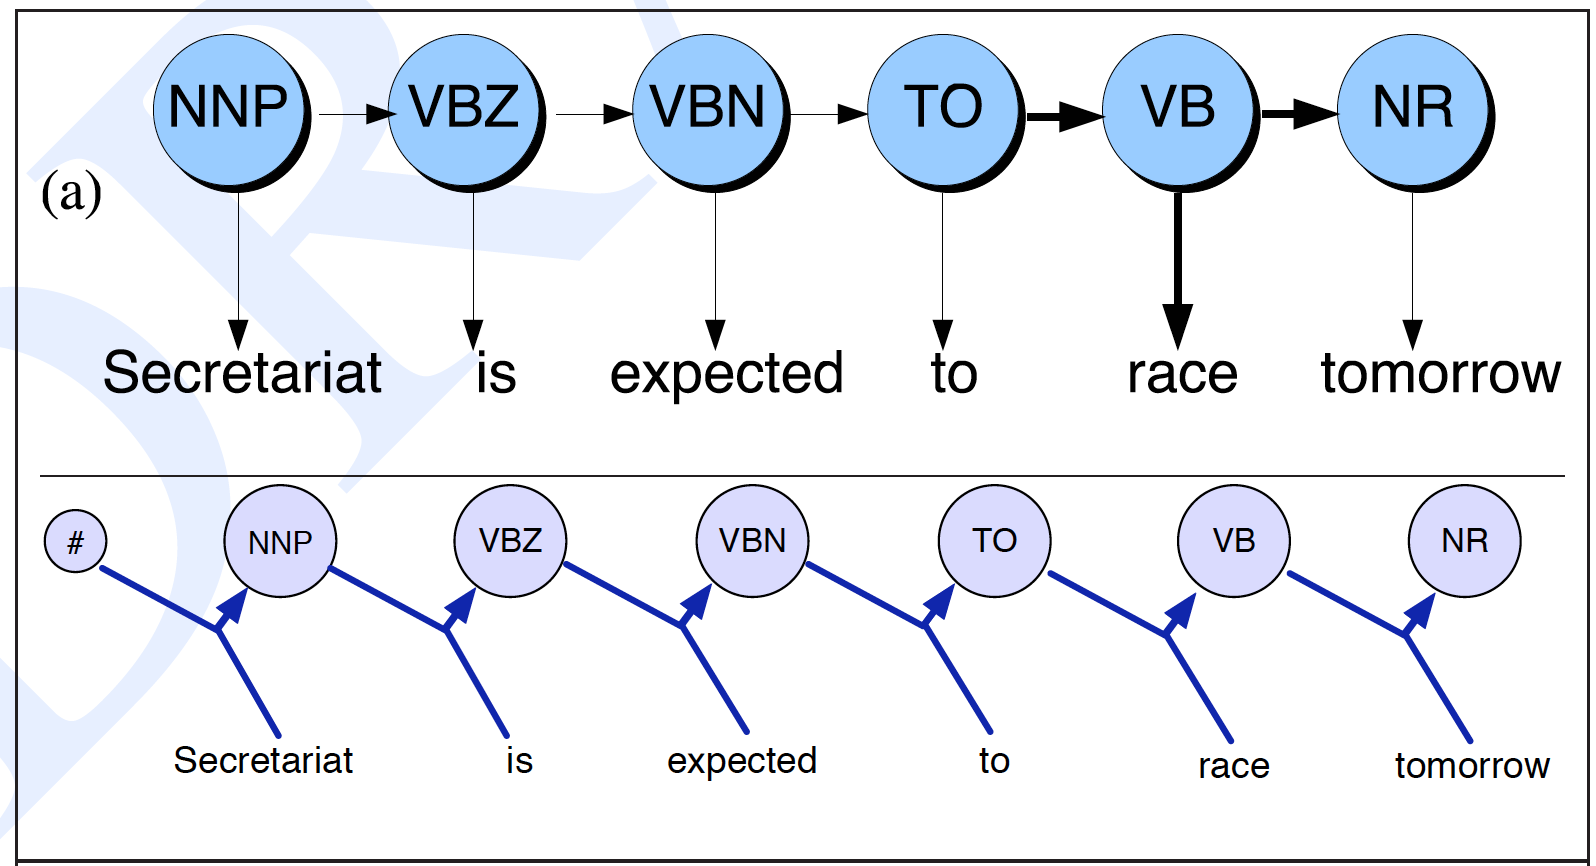

In [837]:
from IPython.display import Image, display
display(Image(filename='/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/BASIC_TOPICS/NLP/FIGS/hmm_memm.png',width='50%'))

** b. MEMM w/ Viterbi**

* **HMM Viterbi**: 

    * Update: 
        * Probability Expression: $v_t(j) = max_{i=1}^Nv_{t-1}(i)P(s_j|s_i)P(o_t|s_j)$ for $1\leq j\leq N, 1\leq t\leq T$.
        * Implementation Expression: $v_t(j) = max_{i=1}^Nv_{t-1}(i)a_{ij}b_j(o_t)$ for $1\leq j\leq N, 1\leq t\leq T$.
    
    * Notation: 
        * $v_t(j)$: a cell's probability in Viterbi matrix at time $t$ and state $j$. 
        * $a_{ij}$: transition probability from state $i$ to state $j$.
        * $b_j(o_t)$: emission probability at state $j$ and time $t$.
        

* **MEMM Viterbi**:

    * Update:
        * Probability Expression: $v_t(j) = max_{i=1}^Nv_{t-1}(i)P(s_j|s_i,o_t)$ for $1\leq j\leq N, 1\leq t\leq T$.
        * Implementation Expression: $v_t(j) = max_{i=1}^Nv_{t-1}(i)maxent(s_j|f_j)$ for $1\leq j\leq N, 1\leq t\leq T$.
        
    * Notation: 
        * $maxent(s_j|f_j)$: the probability of state $s_j$ given feature set $f_j$ of $s_j$ according to a MaxEnt Classifier, which can be anything (e.g. the words 2 words away).

### B. Supervised MEMM

** Setup **

* Data: Brown Corpus (subset size=5000).
* Task: POS-Tagging.
* Decoder: Viterbi.
* Subclassifier: MaxEnt (L-BFGS).

**NB**: 

* Presented as a demo, the number of features is small and randomly picked out of whim, therefore the performance is acceptable as long as it's higher than random guess (i.e. 1/size of tagset = 7%).

* For an unsupervised version, one only needs to integrate Forward-Backward Algorithm into the current code. This is omitted here since there is already a full demo of the method (cf. J&M_03:EM Algorithm).

In [876]:
def load_brown(): # importing tagged brown.
    from nltk.corpus import brown
    print "... loading sentences"
    brown_tagged_sents = brown.tagged_sents(tagset='universal')
    print "... padding sentences"
    brown_tagged_sents = [[('<s>','START')]+s+[('</s>','END')] for s in brown_tagged_sents]
    print "... formatting into ([w,..],[t,..])"
    brown_tagged_sents = [ ([w for w,t in sent],[t for w,t in sent]) for sent in brown_tagged_sents ]
    
    return brown_tagged_sents # train,test: two lists of sents.

In [982]:
%%time
brown_tagged_sents = load_brown()[:5000]

... loading sentences
... padding sentences
... formatting into ([w,..],[t,..])
CPU times: user 5.41 s, sys: 126 ms, total: 5.53 s
Wall time: 5.53 s


In [983]:
import random
import numpy as np
from __future__ import division
from nltk import MaxentClassifier

In [984]:
class MEMM: 
    
    def __init__(self, data, split=.8, max_iter=100, verbose_freq=100): # tagged_train/test are passed.
        print "... extracting info & featurizing data"
        tagset = list({t for (words,tags) in data for t in tags})
        self.i2t = {i:t for i,t in enumerate(tagset)}
        self.t2i = {t:i for i,t in self.i2t.iteritems()}
        featurized = [[( self.featurize(i,self.get_prev_tag(i,tagged_sent),tagged_sent[0]),
                         tagged_sent[1][i] ) 
                       for i in xrange(len(tagged_sent[0]))] 
                      for tagged_sent in data]
        split = int(len(data)*split)
        self.train = featurized[:split]
        self.test = data[split:] # test set is going to be evaluated by viterbi, not maxent, no featurization.
        print "... building subclassifier"
        self.fit(max_iter, verbose_freq)

    def get_prev_tag(self, i, tagged_sent):
        return tagged_sent[0][i-1] if i!=0 else '<B>'        
        
    def featurize(self, w_idx, prev_tag, sent): 
        o = sent[w_idx]
        features = {}
        # 'self' features
        features['word'] = o
        features['sfx0'] = int(o.endswith('ing')) # T/F -> 1/0 conversion.
        features['sfx1'] = int(o.endswith('ly'))
        features['sfx2'] = int(o.endswith('ion'))
        features['sfx3'] = int(o.endswith('s') or o.endswith('es'))
        features['sfx4'] = int(o.endswith('ble'))
        features['pfx0'] = int(o.startswith('con'))
        features['pfx1'] = int(o.startswith('de'))
        features['pfx2'] = int(o.startswith('un'))
        features['pfx3'] = int(o.startswith('in'))
        features['cap'] = int(o.istitle())
        features['dgt'] = int(o.isdigit())
        # 'context' features
        features['prev_w'] = sent[w_idx-1] if w_idx!=0 else '<b>'
        features['next_w'] = sent[w_idx+1] if w_idx!=len(sent)-1 else '</b>'
        features['prev_tag'] = prev_tag
        return features
    
    def fit(self, max_iter, verbose_freq):
        maxent = MaxentClassifier
        for i in xrange(len(self.train)):
            if i!=0 and i%verbose_freq==0:
                print "    ... trained %d sentences" % i
            maxent = maxent.train(self.train[i], algorithm='megam', trace=3, max_iter=max_iter)
        self.maxent = maxent
        self.prob = lambda s,f_idx,prev_tag,sent: \
                    self.maxent.prob_classify(self.featurize(f_idx,prev_tag,sent)).prob(self.i2t[s])

    def viterbi(self, sent):
        N, T = len(self.i2t), len(sent)
        viterbi = np.zeros((N,T))
        backpointer = np.zeros((N,T),dtype=int)
        for s in xrange(N):
            viterbi[s][1] = self.prob(s,1,'START',sent)
            backpointer[s][1] = 0
        for t in xrange(2,T):
            for s in xrange(N):
                viterbi[s][t] = max(viterbi[s_prime][t-1] * self.prob(s,t,self.i2t[s_prime],sent) 
                                    for s_prime in xrange(N))
                backpointer[s][t] = np.argmax([viterbi[s_prime][t-1] * self.prob(s,t,self.i2t[s_prime],sent) 
                                               for s_prime in xrange(N)])
        max_state = self.t2i['END']
            # max_state = np.argmax(viterbi[:,-1])
        best_tagged_seq = []
        for t in reversed(xrange(0,T)):
            best_tagged_seq.insert(0, (sent[t],self.i2t[max_state]))
            max_state = backpointer[max_state][t]
        return best_tagged_seq
    
    def evaluate(self, sample_size=100, verbose_freq=10):
        samples = random.sample(self.test,sample_size)
        accuracies = []
        for i,sample in enumerate(samples): # sample: ([w,..],[t,..]).
            if i!=0 and i%verbose_freq==0:
                print "... evaluated %d sentences" % i
            true = zip(sample[0],sample[1]) # [(w,t),..].
            pred = self.predict(sample[0]) # predict on sent.
            correct = sum(pred_i==true_i for pred_i,true_i in zip(pred,true))
            accuracies.append(correct/len(true))
        print "Accuracy (%d samples): %.2f%%" % (sample_size,np.mean(accuracies)*100) 
    
    def predict(self, sent):
        if type(sent)==str:
            sent = ['<s>'] + sent.split() + ['</s>']
        return self.viterbi(sent)
    

In [985]:
%%time
memm = MEMM(brown_tagged_sents,verbose_freq=100)

... extracting info & featurizing data
... building subclassifier
    ... trained 100 sentences
    ... trained 200 sentences
    ... trained 300 sentences
    ... trained 400 sentences
    ... trained 500 sentences
    ... trained 600 sentences
    ... trained 700 sentences
    ... trained 800 sentences
    ... trained 900 sentences
    ... trained 1000 sentences
    ... trained 1100 sentences
    ... trained 1200 sentences
    ... trained 1300 sentences
    ... trained 1400 sentences
    ... trained 1500 sentences
    ... trained 1600 sentences
    ... trained 1700 sentences
    ... trained 1800 sentences
    ... trained 1900 sentences
    ... trained 2000 sentences
    ... trained 2100 sentences
    ... trained 2200 sentences
    ... trained 2300 sentences
    ... trained 2400 sentences
    ... trained 2500 sentences
    ... trained 2600 sentences
    ... trained 2700 sentences
    ... trained 2800 sentences
    ... trained 2900 sentences
    ... trained 3000 sentences
    ... train

In [986]:
%%time
memm.evaluate()

... evaluated 10 sentences
... evaluated 20 sentences
... evaluated 30 sentences
... evaluated 40 sentences
... evaluated 50 sentences
... evaluated 60 sentences
... evaluated 70 sentences
... evaluated 80 sentences
... evaluated 90 sentences
Accuracy (100 samples): 35.71%
CPU times: user 2min 50s, sys: 551 ms, total: 2min 50s
Wall time: 2min 50s
